# Adams-Bashforth Multistep Methods

% TO DO
% - For the (undamped) mass-spring system, replace orbit graphs by looking at the error in the conserved energy.

**References:**

- Section 6.7 *Multistep Methods* in {cite}`Sauer`.
- Section 5.6 *Multistep Methods* in {cite}`Burden-Faires`.

## Introduction

Recall from {doc}`ODE-IVP-6-multi-step-methods-introduction`:

```{prf:definition} Multistep Method
:label: multistep-method-redux

A **multistep method** for numerical solution of an ODE IVP $du/dt = f(t, u)$, $u(t_0) = u_0$ is one of the form

$$ U_{i} = \phi(U_{i-1}, \dots U_{i-s}, h), \quad s > 1 $$

so that the new approximate value of $u(t)$ depends on approximate values at multiple previous times.
(The shift of indexing to describe "present" in terms of "past" wil be convenient here.)

This is called an $s$-step method: the Runge-Kutta family of methods are all one-step.
```

We will be more specifically interted in what are called **linear multistep methods**,
where the function at right is a linear combination of value of $u(t)$ and $f(t, u(t))$.

So for now we look at

$$U_{i} = a_0 U_{i-s} + \dots + a_{s-1} U_{i-1} + h (b_0 f(t_{i-s}, U_{i-s}) + \dots + b_{s-1} f(t_{i-1}, U_{i-1})) $$

The **Adams-Bashforth** methods are a case of this with the only $a_i$ term being $a_{s-1} = 1$:

$$U_{i} = U_{i-1} + h (b_0 f(t_{i-s}, U_{i-s}) + \dots + b_{s-1} f(t_{i-1}, U_{i-1})) $$

As wil be verified later, the $s$-step version of this is accurate to order $s$,
so one can get arbitrarily high order of accuracy by using enough steps.

**Aside.** The case $s=1$ is Euler's method, now written as

$$U_{i} = U_{i-1} + h f(t_{i-1}, U_{i-1})$$

The Adams-Bashforth methods are probably the most comomnly used **explicit**, **one-stage** multi-step methods;
we will see more about the alternatives of **implicit** and **multi-stage** options in future sections.
(Note that all Runge-Kutta methods (except Euler's) are multi-stage: the explicit trapezoid and midpoint methods are 2-stage; the classical Runge-Kutta method is 4-stage.)

The most basic **Adams-Bashforth** multi-step method is the 2-step method, which can be thought of this way:

1. Start with the two most recent values, $U_{i-1} \approx u(t_{i) - h}$ and $U_{i-2} \approx u(t_i - 2h)$

2. Use the derivative approximations
$F_{i-1} := f(t_{i-1}, U_{i-1}) \approx u'(t_{i-1})$ and $F_{i-2} := f(t_{i-2}, U_{i-2}) \approx u'(t_{i-2})$
and linear extrapolation to "predict" the value of $u'(t_i - h/2)$; one gets:
$u'(t_i - h/2) \approx \frac{3}{2} u'(t_i - h) - \frac{1}{2}u'(t_i - 2h) \approx \frac{3}{2} F_{i-1} - \frac{1}{2}F_{i-2}$

3. Use this in the centered difference approximation

$$\frac{u(t_{i}) - u(t_{i-1})}{h} \approx u'(t_i - h/2)$$

to get

$$\frac{U_{i} - U_{i-1}}{h} \approx \frac{3}{2} F_{i-1} - \frac{1}{2} F_{i-2}$$

That is,

$$
U_{i} = U_{i-1} + \frac{h}{2} \left( 3 F_{i-1} - F_{i-2} \right), = U_{i-1} + \frac{h}{2} \left( 3 f(t_{i-1}, U_{i-1}) - f(t_{i-2}, U_{i-2}) \right)
$$ (adams-bashforth-2)

Equivalently, one can

1. Find the collocating polynomial $p(t)$ through $(t_{i-1}, F_{i-1})$ and $(t_{i-2}, F_{i-2})$ [so just a line in this case]

2. Use this on the interval $(t_{i-1}, t_{i})$ (*extrapolation*) as an approximation of $u'(t) = f(t, u(t))$ in that interval.

3. Use

$$\displaystyle u(t_{i}) = u(t_{i-1}) + \int_{t_{i-1}}^{t_{i}} u'(\tau) d \tau \approx u(t_{i-1}) + \int_{t_{i-1}}^{t_{i}} p(\tau) d \tau,$$

where the latter integral is easy to evaluate exactly.

One does not actually do this in each case; it is enough to verify that the integral gives
$\left( \frac{3}{2} F_{i-1} - \frac{1}{2} F_{i-2} \right) h$.

See [Exercise 1](#exercise-1).

To code this algorithm, it is convenient to shift the indices, to get a formula for $U_i$.
Also, note that what is $F_i = f(t_i, U_i)$ at one step is reused as $F_{i-1} = f(t_{i-1}, U_{i-1})$ at the next,
so to avoid redundant evaluations of $f(t, u)$, these quantities should also be saved, at least till the next step:

$$U_{i} = U_{i-1} + \frac{h}{2} \left( 3 F_{i-1} - F_{i-2} \right)$$

In [1]:
using PyPlot

In [2]:
include("NumericalMethods.jl")

Main.NumericalMethods

In [3]:
import .NumericalMethods as NM

In [4]:
function adamsbashforth2(f, a, b, U_0, U_1, n)
    n_unknowns = length(U_0)
    t = range(a, b, n+1)
    u = zeros(n+1, n_unknowns)
    u[1,:] = U_0
    u[2,:] = U_1
    F_i_2 = f(a, U_0)  # F_0 to start when computing U_2
    h = (b-a)/n
    for i in 2:n  # i is the mathematical index, so "+1" for Julia array indices
        F_i_1 = f(t[i], u[i,:])
        u[i+1,:] = u[i,:] + (3*F_i_1 - F_i_2) * (h/2)
        F_i_2 = F_i_1
    end
    return (t, u)
end;

### Demonstrations with the mass-spring system

In [5]:
f_mass_spring(t, u) = [ u[2]; -(K/M)*u[1] - (D/M)*u[2] ];

In [6]:
using .NumericalMethods: y_mass_spring

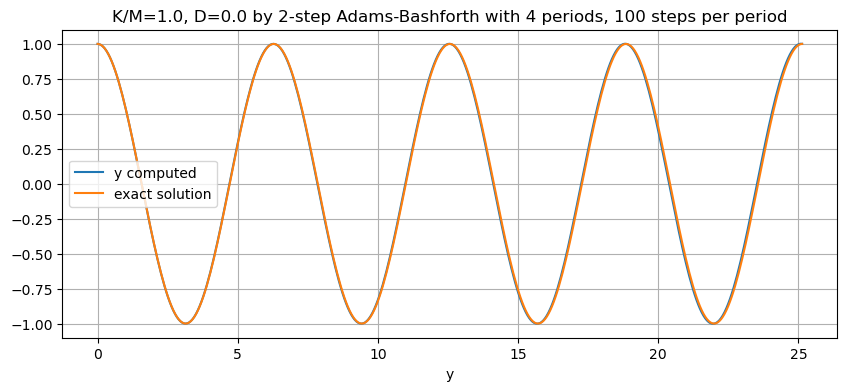

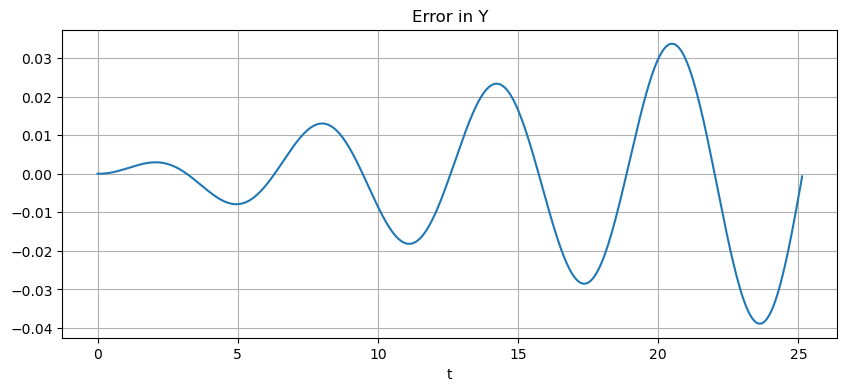

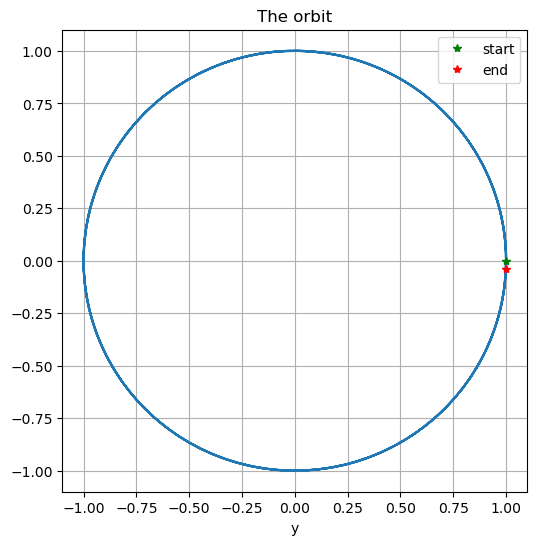

In [7]:
M = 1.0
K = 1.0
D = 0.0
y_0 = 1.0
v_0 = 0.0
U_0 = [y_0, v_0]
a = 0.0
periods = 4
b = 2pi * periods

# Using the same time step size as with the leapfrog method in the previous section.
stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1, and get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the time cost is negligible.
h = (b-a)/n
(t_1step, U_1step) = NM.rungekutta_system(f_mass_spring, a, a+h, U_0, 1)
U_1 = U_1step[end,:]
(t, U) = adamsbashforth2(f_mass_spring, a, b, U_0, U_1, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 2-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
xlabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5.5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbit")
plot(Y, DY)
xlabel("y")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

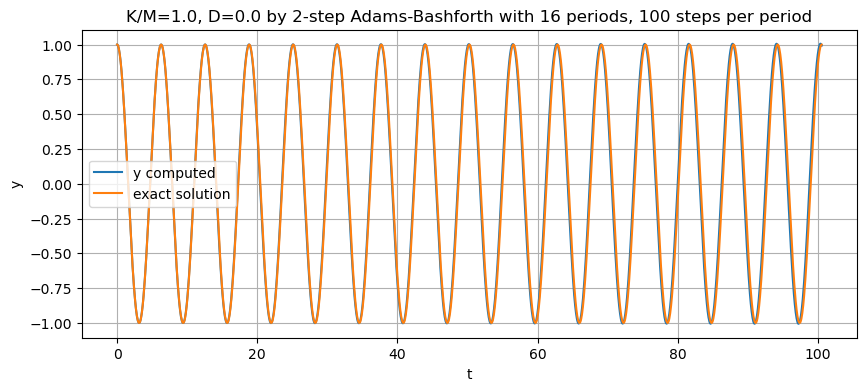

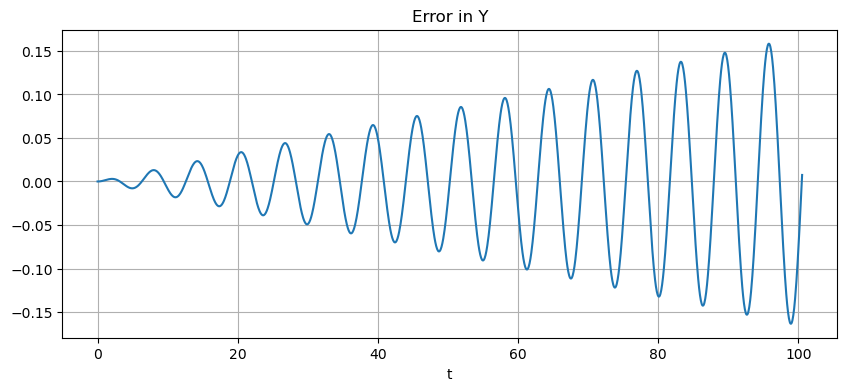

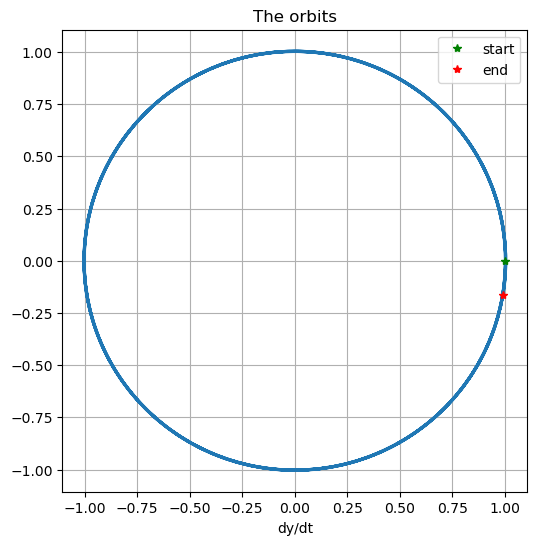

In [8]:
D = 0.0

periods = 16
b = 2pi * periods

# Using the same time step size as with the leapfrog method in the previous section.
stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1, and get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the time cost is negligible.
h = (b-a)/n
(t_1step, U_1step) = NM.rungekutta_system(f_mass_spring, a, a+h, U_0, 1)
U_1 = U_1step[end,:]
(t, U) = adamsbashforth2(f_mass_spring, a, b, U_0, U_1, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 2-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5.5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbits")
plot(Y, DY)
xlabel("y")
xlabel("dy/dt")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

In comparison to the (also second order accurate) leap-frog method, this is distinctly worse;
the errors are more than twice as large, and the solution fails to stay on the circle;
unlike leapfrog, the energy $E(t) = \frac{1}{2}(y^2(t) + Dy^2(t))$ is not conserved.

On the other hand ...

### This time with damping, nothings goes wrong!

This is an example in **stability**;
in future sections it will be seen that the the Adams-Bashforth methods are all stable for these equations for small enough step size $h$,
and so converge to the correct solution as $h \to 0$.

Looking back, this suggests (correctly) that while the leapfrog method is well-suited to *conservative* equations, Adams-Bashforth methods are much preferable for more general equations.

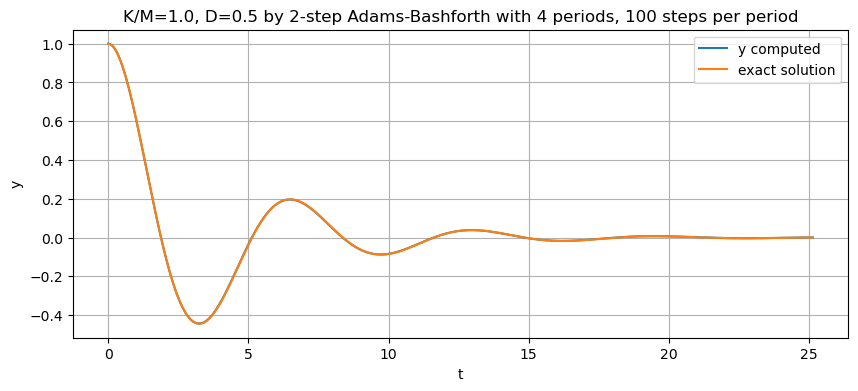

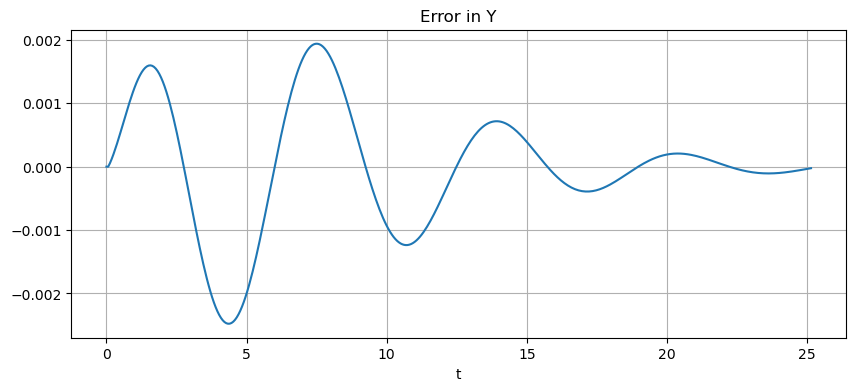

In [9]:
D = 0.5

periods = 4
b = 2pi * periods

# Using the same time step size as with the leapfrog method in the previous section.
stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1, and get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the time cost is negligible.
h = (b-a)/n
(t_1step, U_1step) = NM.rungekutta_system(f_mass_spring, a, a+h, U_0, 1)
U_1 = U_1step[end,:]
(t, U) = adamsbashforth2(f_mass_spring, a, b, U_0, U_1, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 2-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

## Higher order Adams-Bashforth methods

The strategy described above of polynomial approximation, extrapolation, and integration can be generalized to get the $s$ step Adams-Bashforth method, of order $s$;
to get the approximation $U_i$ of $u(t_i)$ from data at the $s$ most recent previous times $t_{i-1}$ to $t_{i-s}$:

1. Find the collocating polynomial $p(t)$ of degree $s-1$ through
$(t_{i-1}, F_{i-1}) \dots (t_{i-s}, F_{i-s})$

2. Use this on the interval $(t_{i-1}, t_{i})$ (*extrapolation*) as an approximation of $u'(t) = f(t, u(t))$ in that interval.

3. Use $u(t_{i}) = u(t_{i-1}) + \int_{t_{i-1}}^{t_{i}} u'(\tau) d \tau \approx u(t_{i-1}) + \int_{t_{i-1}}^{t_{i}} p(\tau) d\tau$,
where the latter integral can be evaluated exactly.

Again, one does not actually evaluate this integral; it is enough to verify that the resulting form will be

$$U_{i} = U_{i-1} + h (b_0 F_{i-s} + b_1 F_{i-s+1} + \cdots b_{s-1} F_{i-1})$$

with the coefficients being the same for any $f(t, u)$ and any $h$.

In fact, the polynomial fitting and integration can be skipped: thecoefficients can be derived by the method of undetermined coefficients as seen in
{doc}`derivatives-and-the-method-of-undetermined-coefficents`
and this also established that the local truncation error is $O(h^s)$:
- insert Taylor polynomial approximations of
$u(t_{i-k}) = u(t_i) - k h)$ and
$f(t_{i-k}, u(t_{i-k})) = u'(t_{i-k}) = u'(t_i - k h)$
into
$$U_{i} = U_{i-1} + h (b_0 f(t_{i-s}, U_{i-s}) + \dots + b_{s-1} f(t_{i-1}, U_{i-1})) $$

- solve for the $s$ coefficients $b_0 \dots b_{s-1}$ that give the highest power for the residual error:
the terms in the first $s$ powers of $h$ (from $h^0 = 1$ to $h^{s-1}$) can be cancelled, leaving an error $O(h^s)$.

The first few Adams-Bashforth formulas are:

- $s=1$: $b_0 = 1$,
$$U_{i} = U_{i-1} + h F_{i-1} = U_{i-1} + h f(t_{i-1}, U_{i-1}) \quad \text{(Euler's method)}$$

- $s=2$: $b_0 = -1/2, b_1 = 3/2$,
$$U_{i} = U_{i-1} + \frac{h}{2} \left( 3 F_{i-1} - F_{i-2} \right) \quad \text{(as above)}$$

- $s=3$: $b_0 = 5/12, b_1 = -16/12, b_2 = 23/12$,
$$U_{i} = U_{i-1} + \frac{h}{12} \left( 23 F_{i-1} - 16F_{i-2} + 5 F_{i-3} \right)$$

- $s=4$: $b_0 = -9/24, b_1 = 37/24, b_2 = -59/24, b_3 = 55/24$,
$$U_{i} = U_{i-1} + \frac{h}{24} \left( 55 F_{i-1} - 59 F_{i-2} + 37 F_{i-3} -9 F_{i-4} \right)$$

In [10]:
function adamsbashforth3(f, a, b, U_0, U_1, U_2, n)
    n_unknowns = length(U_0)
    h = (b-a)/n
    t = range(a, b, n+1)
    u = zeros(n+1, n_unknowns)
    u[1,:] = U_0
    u[2,:] = U_1
    u[3,:] = U_2
    F_i_3 = f(a, U_0)  # F_0 to start when computing U_3
    F_i_2 = f(a+h, U_1)  # F_1 to start when computing U_3
    for i in 3:n  # i is the mathematical index, so "+1" for Julia array indices
        F_i_1 = f(t[i], u[i,:])
        u[i+1,:] = u[i,:] + (23F_i_1 - 16F_i_2 + 5F_i_3) * (h/12)
        (F_i_2, F_i_3) = (F_i_1, F_i_2)
    end
    return (t, u)
end;

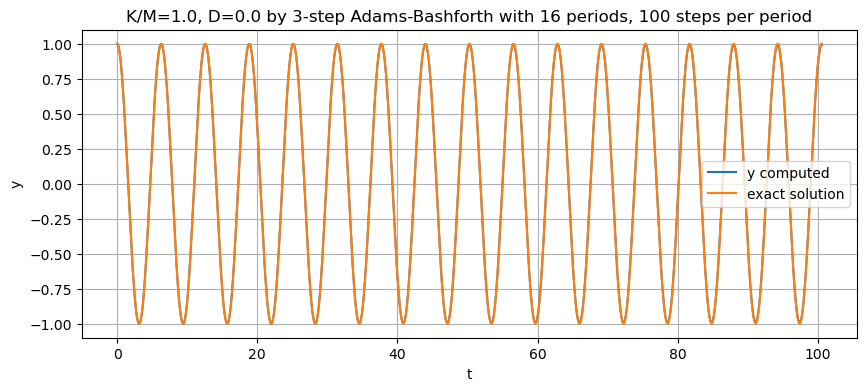

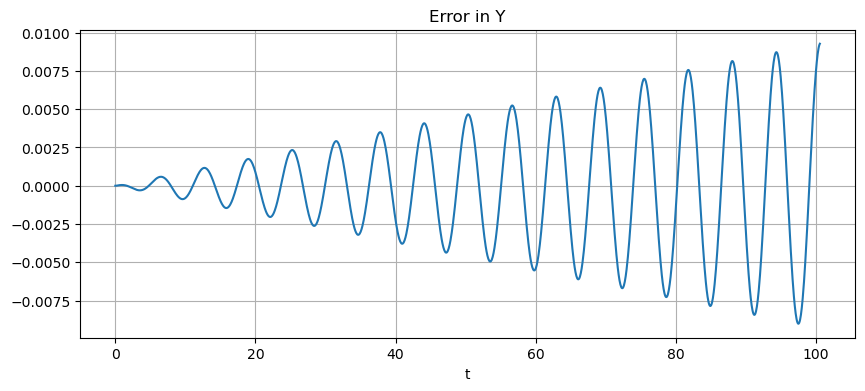

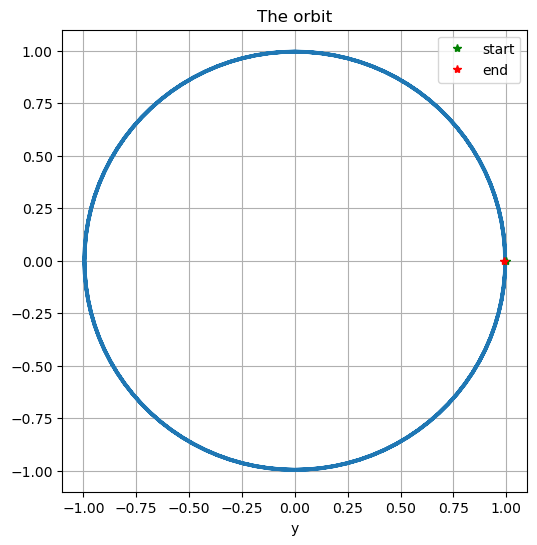

In [11]:
D = 0.0

periods = 16
b = 2pi * periods

# Using the same time step size as for leapfrog method in the previous section.
stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1 and U_2, and get them with the Runge-Kutta method;
# this is overkill for accuracy, but since only two steps are needed, the time cost is negligible.
h = (b-a)/n
(t_2step, U_2step) = NM.rungekutta_system(f_mass_spring, a, a+2h, U_0, 2)
U_1 = U_2step[2,:]
U_2 = U_2step[3,:]
(t, U) = adamsbashforth3(f_mass_spring, a, b, U_0, U_1,U_2, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 3-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5.5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbit")
plot(Y, DY)
xlabel("y")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

Comparing to the leap-frog method, this higher order method at last has smaller errors (and they can be got even smaller by increasing the number of steps)
but the leapfrog method is still better at keeping the solutions on the circle.

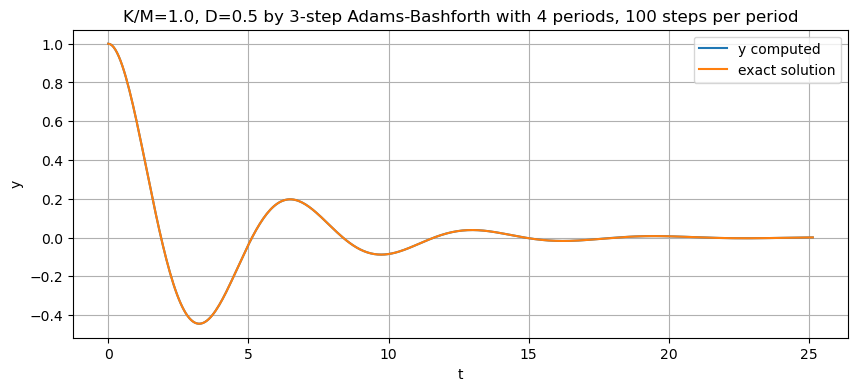

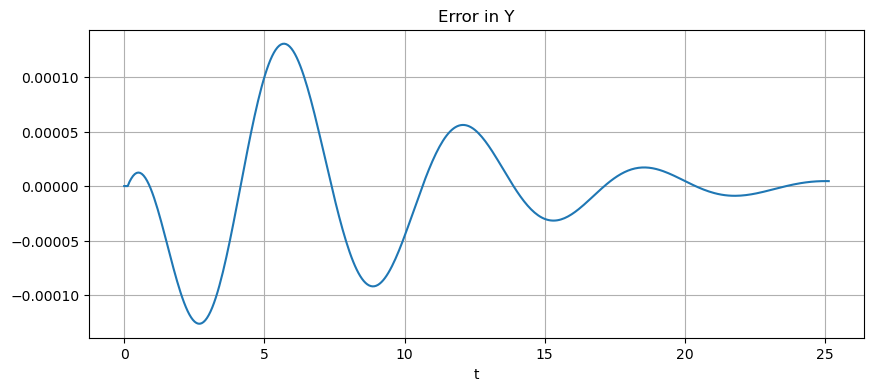

In [12]:
D = 0.5

periods = 4
b = 2pi * periods

# Note: In the notes on systems, the second order Runge-Kutta methods were tested with 50 steps per period
#stepsperperiod = 50  # As for the second order accurate explicit trapezoid and midpoint methods
stepsperperiod = 100  # Equal cost per unit time as for the explicit trapezoid and midpoint and Runge-Kutta methods
n = Int(stepsperperiod * periods)

# We need U_1 and U_2, and get them with the Runge-Kutta method;
# this is overkill for accuracy, but since only two steps are needed, the time cost is negligible.
h = (b-a)/n
(t_2step, U_2step) = NM.rungekutta_system(f_mass_spring, a, a+2h, U_0, 2)
U_1 = U_2step[2,:]
U_2 = U_2step[3,:]
(t, U) = adamsbashforth3(f_mass_spring, a, b, U_0, U_1,U_2, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 3-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

The fourth-order, four step method does at last appear to surpass leap-frog on the conservative case:

In [13]:
function adamsbashforth4(f, a, b, U_0, U_1, U_2, U_3, n)
    n_unknowns = length(U_0)
    h = (b-a)/n
    t = range(a, b, n+1)
    u = zeros(n+1, n_unknowns)
    u[1,:] = U_0
    u[2,:] = U_1
    u[3,:] = U_2
    u[4,:] = U_3
    F_i_4 = f(a, U_0)  # F_0 to start when computing U_4
    F_i_3 = f(a+h, U_1)  # F_1 to start when computing U_4
    F_i_2 = f(a+2h, U_2)  # F_1 to start when computing U_4
    h = (b-a)/n
    for i in 4:n  # i is the mathematical index, so "+1" for Julia array indices
        F_i_1 = f(t[i], u[i,:])
        u[i+1,:] = u[i,:] + (55F_i_1 - 59F_i_2 + 37F_i_3 - 9F_i_4) * (h/24)
        (F_i_2, F_i_3, F_i_4) = (F_i_1, F_i_2, F_i_3)
    end
    return (t, u)
end;

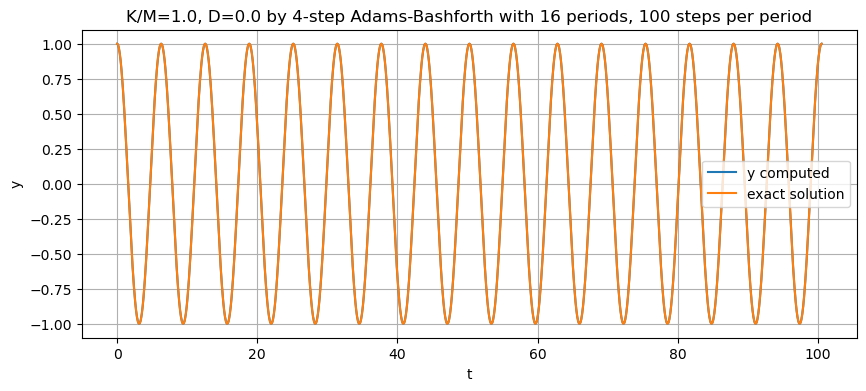

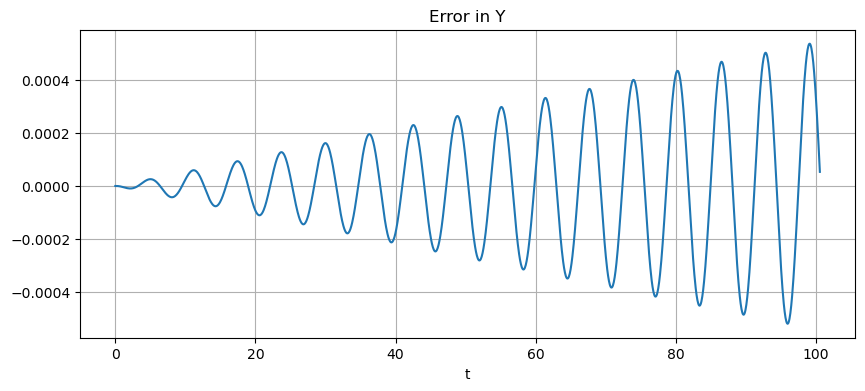

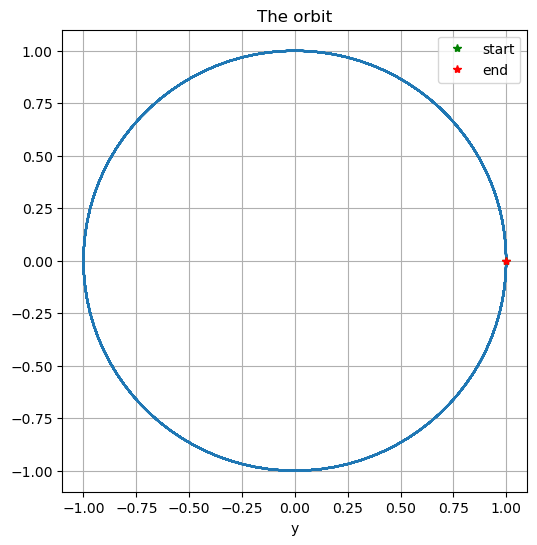

In [14]:
D = 0.0

periods = 16
b = 2pi * periods

# Using the same time step size as for leapfrog method in the previous section.
stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1, U_2 and U_3, and get them with the Runge-Kutta method;
# this is overkill for accuracy, but since only three steps are needed, the time cost is negligible.
h = (b-a)/n
(t_3step, U_3step) = NM.rungekutta_system(f_mass_spring, a, a+3h, U_0, 3)
U_1 = U_3step[2,:]
U_2 = U_3step[3,:]
U_3 = U_3step[4,:]
(t, U) = adamsbashforth4(f_mass_spring, a, b, U_0, U_1, U_2, U_3, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 4-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5.5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbit")
plot(Y, DY)
xlabel("y")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

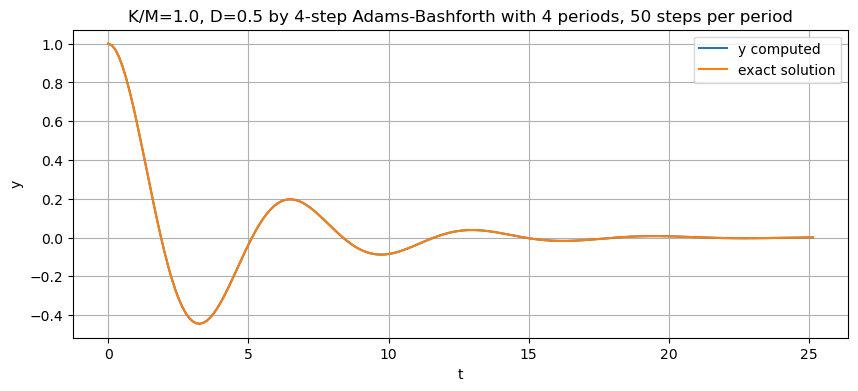

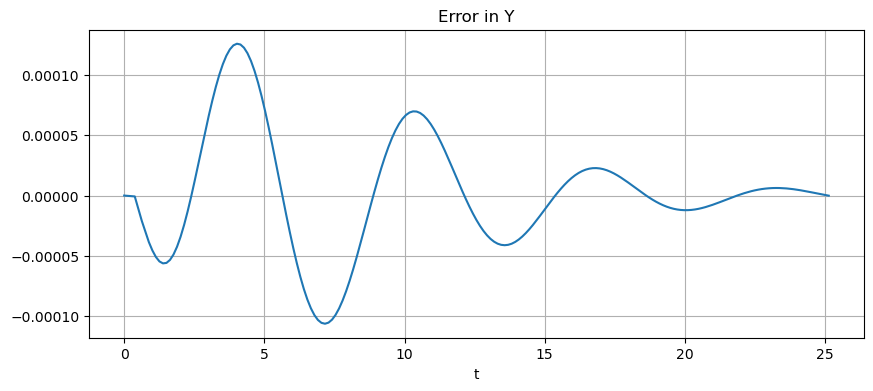

In [15]:
D = 0.5

periods = 4
b = 2pi * periods

# Using the same time step size as for leapfrog method in the previous section.
stepsperperiod = 50
n = Int(stepsperperiod * periods)

# We need U_1, U_2 and U_3, and get them with the Runge-Kutta method.
h = (b-a)/n
(t_3step, U_3step) = NM.rungekutta_system(f_mass_spring, a, a+3h, U_0, 3)
U_1 = U_3step[2,:]
U_2 = U_3step[3,:]
U_3 = U_3step[4,:]
(t, U) = adamsbashforth4(f_mass_spring, a, b, U_0, U_1, U_2, U_3, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 4-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

Finally, an "equal cost" comparison to the forht order Runge-Kutta method results in section
{doc}`ODE-IVP-4-system-higher-order-equations`
with four times as many steps per unit time: the fourth order Adams-Bashforth method come out ahead in these two test cases.

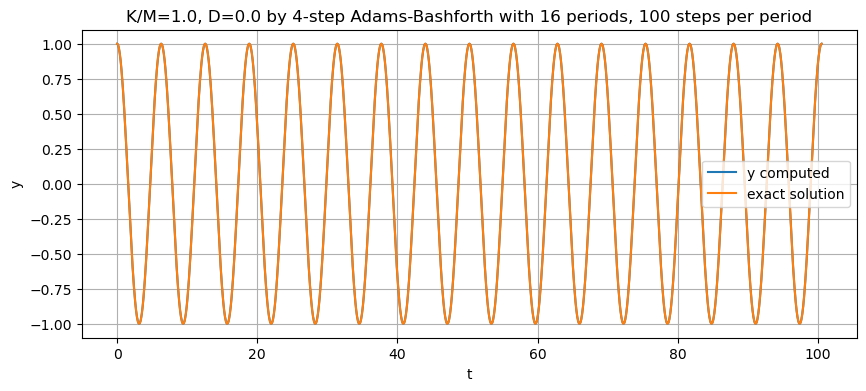

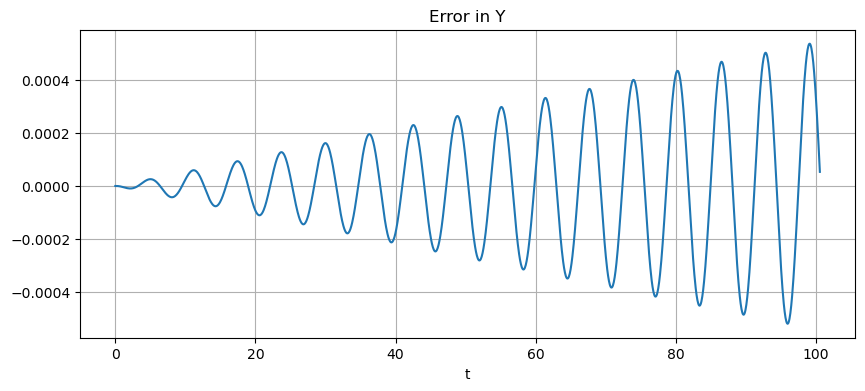

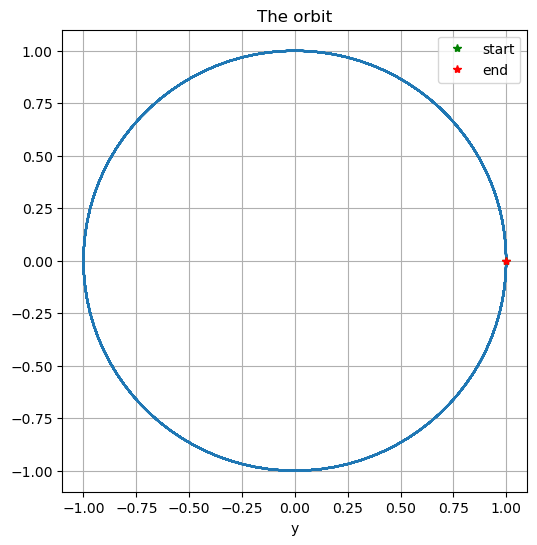

In [16]:
D = 0.0

periods = 16
b = 2pi * periods

stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1, U_2 and U_3, and get them with the Runge-Kutta method;
# this is overkill for accuracy, but since only three steps are needed, the time cost is negligible.
h = (b-a)/n
(t_3step, U_3step) = NM.rungekutta_system(f_mass_spring, a, a+3h, U_0, 3)
U_1 = U_3step[2,:]
U_2 = U_3step[3,:]
U_3 = U_3step[4,:]
(t, U) = adamsbashforth4(f_mass_spring, a, b, U_0, U_1, U_2, U_3, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 4-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

figure(figsize=[5.5])  # Make axes equal length; orbits should be circular or "circular spirals"
title("The orbit")
plot(Y, DY)
xlabel("y")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

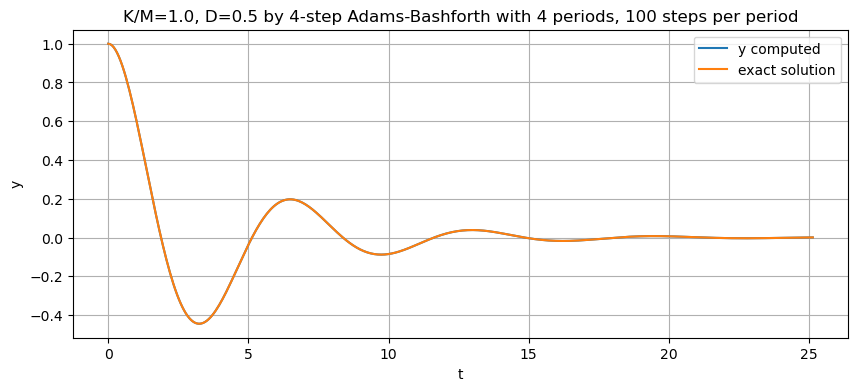

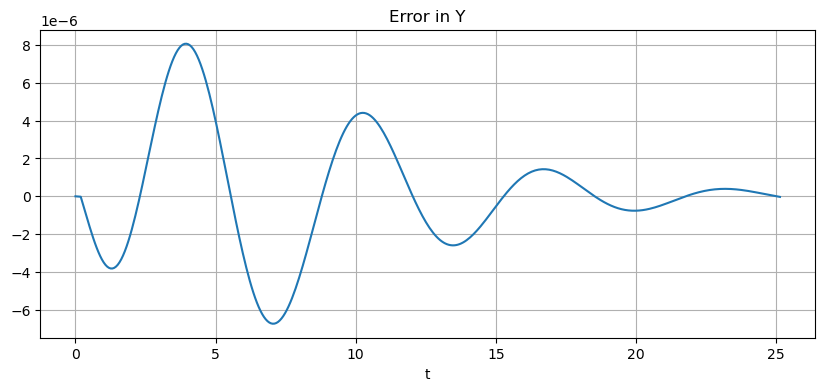

In [17]:
D = 0.5

periods = 4
b = 2pi * periods

# Using the same time step size as for leapfrog method in the previous section.
stepsperperiod = 100
n = Int(stepsperperiod * periods)

# We need U_1, U_2 and U_3, and get them with the Runge-Kutta method;
# this is overkill for accuracy, but since only three steps are needed, the time cost is negligible.
h = (b-a)/n
(t_3step, U_3step) = NM.rungekutta_system(f_mass_spring, a, a+3h, U_0, 3)
U_1 = U_3step[2,:]
U_2 = U_3step[3,:]
U_3 = U_3step[4,:]
(t, U) = adamsbashforth4(f_mass_spring, a, b, U_0, U_1, U_2, U_3, n)

Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=U_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,3])
title("K/M=$(K/M), D=$D by 4-step Adams-Bashforth with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
legend()
xlabel("t")
ylabel("y")
grid(true)

figure(figsize=[10,3])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

---
## Exercises

<a name="exercise-1"></a>
### Exercise 1

Verify the derivation of Equation {eq}`adams-bashforth-2` for the second order Adams-Bashforth method, via polynomial collocation and integration.

<a name="exercise-3"></a>
### Exercise 2
Verify the above result for $s=3$ by the method of undetermined coefficients.